# Fitting Complex Dynamics Models with a Bayesian Approach

For a review of the Bayesian approach I personally recommend this short 5-part series Blogs: http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/


In short, when we fit linear model using glm it uses **maximum likelihood** *aka* **MLE**.

I decided to do the same, but using **Bayesian** approach. More or less, what it does - it probes parameter space of all model parameters $\theta$ and calculates the conditional likelihood of chosen model parameters, given all data points:
$$
L(\theta | D) = \frac{L(D | \theta) f(\theta)}{\int L(D | \theta^\prime)f(\theta^\prime)d\theta^\prime} \ \ \ \ \ \ ,
$$
where $L(D | \theta)$ is the likelihood (same as in MLE). $L(\theta | D)$ is posterior. $f(\theta)$ is prior.

As model parameters grow, it becomes computationally impossible to straight up probe the entire parameter space for $\theta$. Instead, Markov Chain Monte-Carlo(MCMC) methods are used. There are different variations for sampling algorithms, such as Metropolis-Hastings, Gibbs. There are more sophisticated once out there.

Integral in the denominator is irrelevant in MCMC.

Another interesting fact is that there is absolutely **no overfitting** in the Bayesian approach... Huh? Interesting, right? This is due to the fact that there is no optimization in the procedure. It's a pure calculation of likelihoods.

In [2]:
# Load libraries
library(rstan)
library(ggplot2)
library(sn) # Skew-normal
library(psych) # describe
#library(MillimanPM)
library(dplyr)

library(rstanarm) # stan_glm
library(bayesplot)# mcmc_areas
source("./WDUtilityFunctions.R")

print(R.Version()$version.string)
printversion(c("rstan", "ggplot2", "sn", "psych", "dplyr", "rstanarm", "bayesplot"))

[1] "R version 3.3.1 (2016-06-21)"
[1] "rstan version 2.12.1"
[1] "ggplot2 version 2.2.0"
[1] "sn version 1.4.0"
[1] "psych version 1.6.12"
[1] "dplyr version 0.5.0"
[1] "rstanarm version 2.13.1"
[1] "bayesplot version 1.0.0"


## Withdrawal Toy Model

Here, I'm going to build a simulated toy model for some integer outcome, say number of withdrawals in the next 10 quarters. In the end I'm interested in the estimation of model parameters and 
 * Time of the first withdrawal PDF
 * Number of Withdrawals PDF

Let us say we have consecutive 10 quarters withdrawal data for 100 or 1000 people.
Each observation is a **binary** event (1 or 0) - whether a person took a withdrawal in the quarter or not.

We will also have an instantaneous *jump* in the withdrawal probability right after the first withdrawal. This is to simulate the fact that once people start withdrawing, they are more likely to withdraw in the next quarter than before the first withdrawal happens.

Each person has a *base withdrawal probability* that can be different from a different person.
For example, maybe there is another parameter (income or credit score) that we do not have data for that affects overall
withdrawal probability.

The base withdrawal probability is drawn from a normal PDF with a predefined mean and variance. Once drawn, it stays the same for this person. However, we allow the withdrawal probability to **change with time**.


## One Person Simulation algorithm
  1. Draw base logit probability:
  $$ base\_link \sim N(\mu, \sigma)$$
  
  2. Initialize the withdrawal indicator 
  $$WD_{IND} = 0$$
  
  3. Loop $q$ over 10 quarters
     * 3.1 Calculate quarterly probability:
     $$
     p_q = \frac{1}{ 1 + \exp(-base\_link - C_{WD}WD_{IND} - C_qq)},
     $$
     where $C_q$ is a predefined constant.
     * 3.2 Draw Bernoulli result - whether the person withdraws in a given quarter:
     
     $$
     WD_q \sim Bernoulli(p_q)
     $$ 
     
     * 3.3 If $WD_q$ == 1, then set $WD_{IND} = 1$
     
     
So, effectively there are three model parameters:
 * $\mu$ or Intercept - base logit probability
 * $\sigma$ - base logit probability standard deviation
 * $C_q$ - Quarterly coefficient
 * $C_{WD}$ - Jump after the first observed withdrawal
      

# 1. Simulation and a Little bit of Exploration

In [81]:
# Control parameters for simulation
TrueSimulatedPars_Symmetric = list(
     Intercept       = -0.1,  # Intercept term (Base Probability of Withdrawal)
     Intercept_scale = 0.5,   # Uncertainty in Intercept
     Intercept_shape = 0.0,   # Skeweness of Intercept
     Npeople         = 2,   # Number of people
     Nq              = 10,    # Number of Quarters for each person for training
     Nqtot           = 10,    # Total number of Quarters for each person for training
     q_coef          = 0.05,  # Quarter effect
     CJump           = 0.3    # Jump probability
)

In [91]:
source("./WDUtilityFunctions.R")

# Simulate Hundred People
set.seed(54)
df_symmetric = simulate_people(TrueSimulatedPars_Symmetric, 100)

# Simulate Thousand People
set.seed(54)
df_symmetric_1000 = simulate_people(TrueSimulatedPars_Symmetric, 1000)

In [94]:
#saveRDS(df_symmetric, "out/df_symmetric_v5.rds", compress=F)
#saveRDS(df_symmetric_1000, "out/df_symmetric_1000_v5.rds", compress=F)

In [217]:
# First couple of rows of the dataframe
head(df_symmetric_1000,2)

q,WD,wd_prob,wd_prob_link,WD_numeric,NWithdrawals,QFirstWD,person_id,id
1,0,0.2607843,-1.0418959,0,4,3,1,1
2,0,0.2705378,-0.9918959,0,4,3,1,2


### First 20 simulations

As one can see below are first 20 simulations. The first person has overall higher withdrawal probability than the second person. 

Withdrawal probability increases with quarter. In this case it is linear in this simulation. But it is straightforward to add things like shock withdrawals, for example.

In this case **Person 1** has a lower base withdrawal probability than **Person 2**. And also Person 2 had more Withdrawal Events (8 vs 4).

The first withdrawal for **Person 1** happens in the third quarter. For **Person 2** it happened in the second quarter. Right after that we see an instantaneous jump in the simulated withdrawal probabilities.

The withdrawal probability is a hidden variable. It is not allowed to be used in training. It is only for analysis and vizualization.

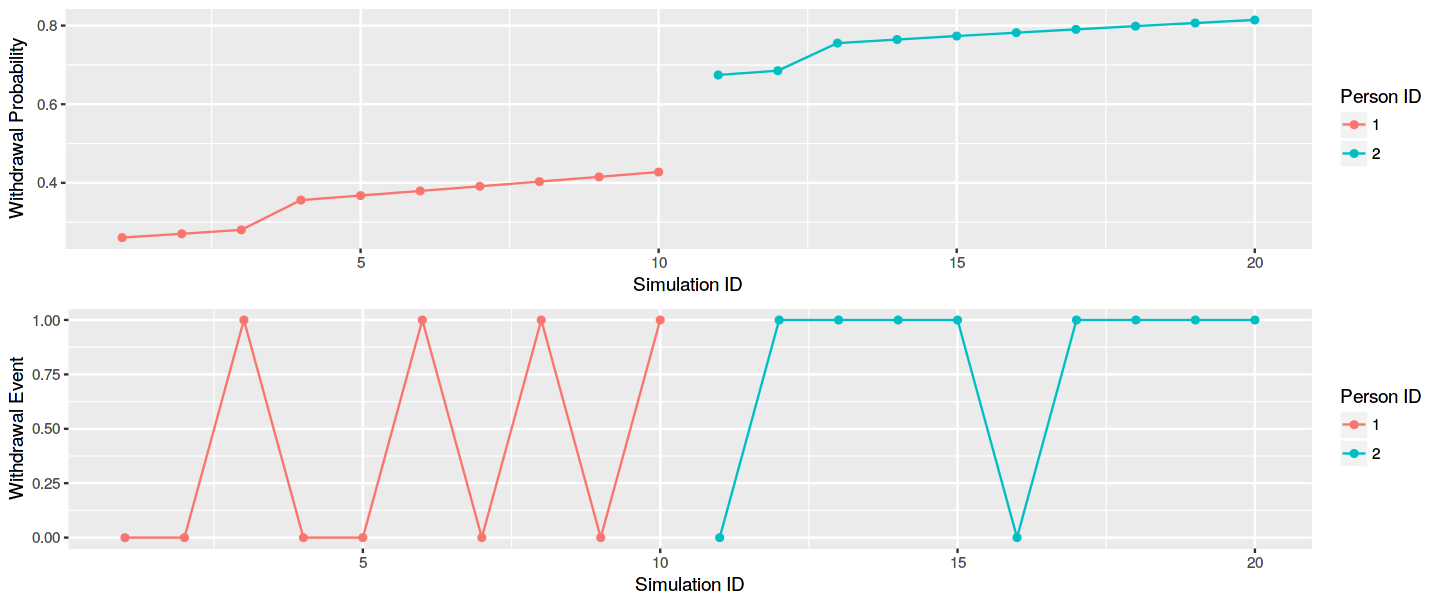

In [218]:
# DataFrame for the first plot
df_plot_1 = df_symmetric_1000[1:20, c("id", "wd_prob", "person_id", "WD")]

# Plot

#png(filename="./Paper/figs/fig1.png")
require(gridExtra)
plot1 = ggplot(df_plot_1, aes(id, wd_prob, color=as.factor(person_id))) + geom_line() + geom_point() + 
    xlab("Simulation ID") + ylab("Withdrawal Probability")+ labs(color='Person ID') 


plot2 = ggplot(df_plot_1, aes(id, WD, color=as.factor(person_id))) + geom_line() + geom_point() + 
    xlab("Simulation ID") + ylab("Withdrawal Event")+ labs(color='Person ID')

grid.arrange(plot1, plot2, ncol=1)

#dev.off()
#write.csv(df_plot_1, "./Paper/data/df_plot_1.csv", row.names=F)

In general, we should see that on average we should see less *Withdrawal Events* in the early quarters than on the later quarters, because we simulated those probabilities to be higher. Also, for later quarters there is a high chance of already experiencing the instantaneous jump.

Here is a Univariate plot of the Withdrawal Event rates as a function quarter:

Warning message:
: Removed 2 rows containing missing values (geom_path).Warning message:
: Removed 2 rows containing missing values (geom_point).Warning message:
: Removed 2 rows containing missing values (geom_errorbar).Warning message:
: Removed 2 rows containing missing values (geom_bar).Warning message:
: Removed 2 rows containing missing values (geom_path).Warning message:
: Removed 2 rows containing missing values (geom_point).Warning message:
: Removed 2 rows containing missing values (geom_errorbar).Warning message:
: Removed 2 rows containing missing values (geom_bar).

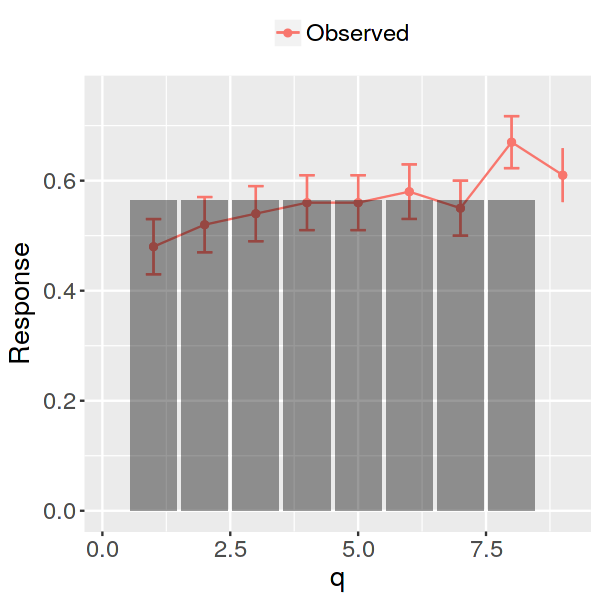

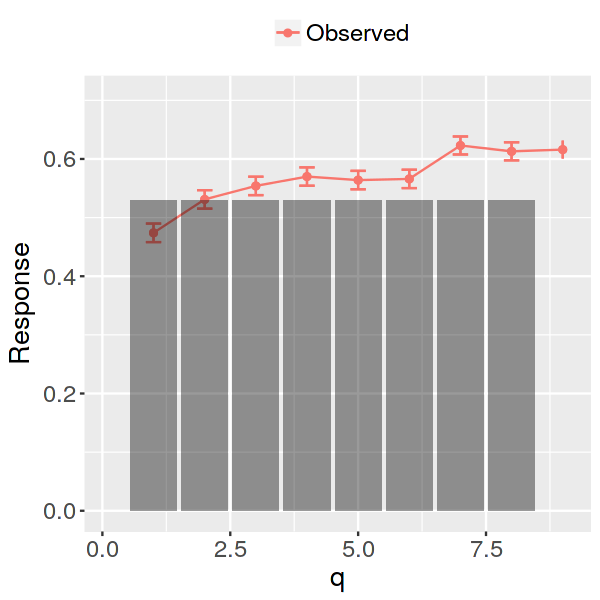

In [219]:
source("./WDUtilityFunctions.R")
options(repr.plot.width=5, repr.plot.height=5)
par(mfrow=c(1,1))
# Average Withdrawal rates as a function of quarter in 100 people sample
Plot.Data.Response(df_symmetric, "q", "WD_numeric")
# Average Withdrawal rates as a function of quarter in 1000 people sample
Plot.Data.Response(df_symmetric_1000, "q", "WD_numeric")

So, we do see an overall higher withdrawal rates in both samples.

### Withdrawal Probability PDF

Overall withdrawal probability pdf is around 0.59 with standard deviation of 0.13 and has a negative skew:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1412  0.4992  0.5930  0.5821  0.6744  0.9136 
  vars     n mean   sd median trimmed  mad  min  max range  skew kurtosis se
1    1 10000 0.58 0.13   0.59    0.59 0.13 0.14 0.91  0.77 -0.38    -0.15  0


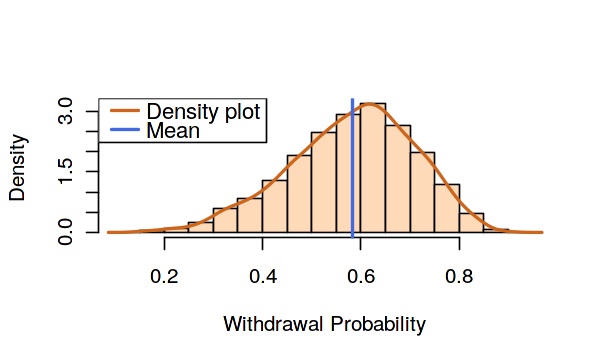

In [220]:
df_plot_2 = df_symmetric_1000$wd_prob


source("./WDUtilityFunctions.R")

#png(filename="./Paper/figs/fig2.png")


options(repr.plot.width=5, repr.plot.height=3)
plot_distribution(df_plot_2,
                  xlab = "Withdrawal Probability",
                  scale_text=0.9, legend_position="topleft", y.intersp=3, text.width_scale=1.2)

#dev.off()
#write.csv(df_plot_2, "./Paper/data/df_plot_2.csv", row.names=F)

## 2. Bayesian Predictive Modeling using Stan

In [103]:
source("./WDUtilityFunctions.R")
# Converting dataframes with simulations to the input data format for Stan
df_symmetric_stan      = get_stan_input(df_symmetric)
df_symmetric_1000_stan = get_stan_input(df_symmetric_1000)

In [128]:
# 2.1 Model 100 people simulation
stan_wd1 = stan(file="./wd_v5.stan", data=df_symmetric_stan, chains=8, iter=2000, cores=8,
                seed = 1
               )
# Exctract result
stan_wd1_result      <- extract(stan_wd1, permuted = TRUE)

In [133]:
# 2.2 Model 1000 people simulation
stan_wd1_1000 = stan(file="./wd_v5.stan", data=df_symmetric_1000_stan, chains=8, iter=2000, cores=8,
                seed = 1
               )
# Exctract result
stan_wd1_1000_result <- extract(stan_wd1_1000, permuted = TRUE)

In [135]:
#saveRDS(stan_wd1_result, "./out/stan_wd1_result_big_v5.rds")
#saveRDS(stan_wd1_1000_result, "./out/stan_wd1_1000_result_big_v5.rds")

# 3. Analysis of the Predictive Model

   ## 3.1 Trace Plots

Trace plots are used to monitor the convergence of MCMC. We should see that the model parameters are converged after the warmup. Warmup in this case is 1000 iterations.

As we can see, both models behave well. All parameters are converged after a few iterations.

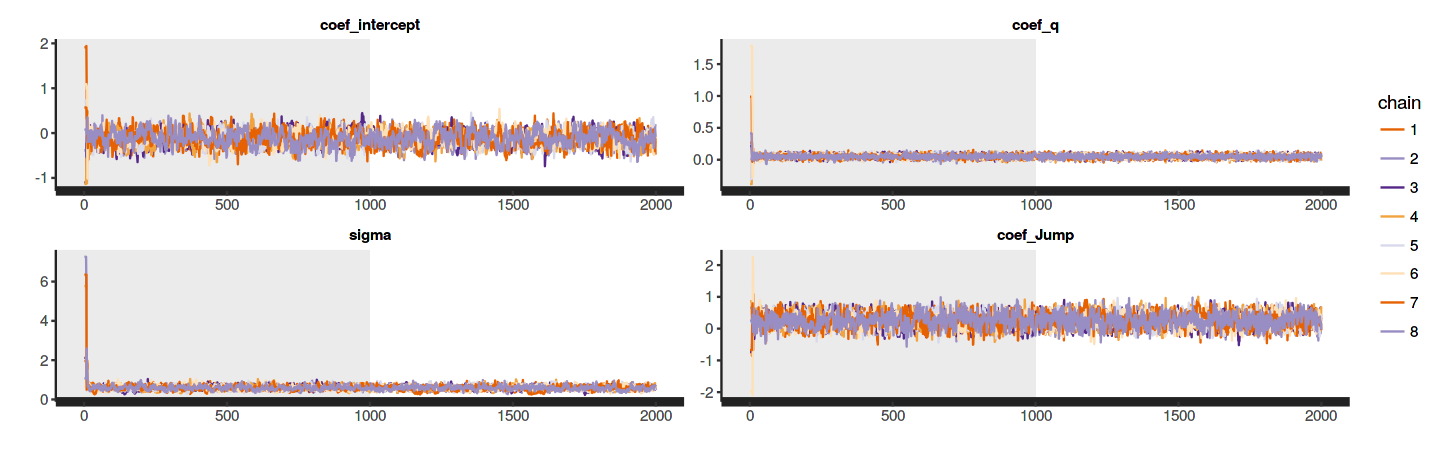

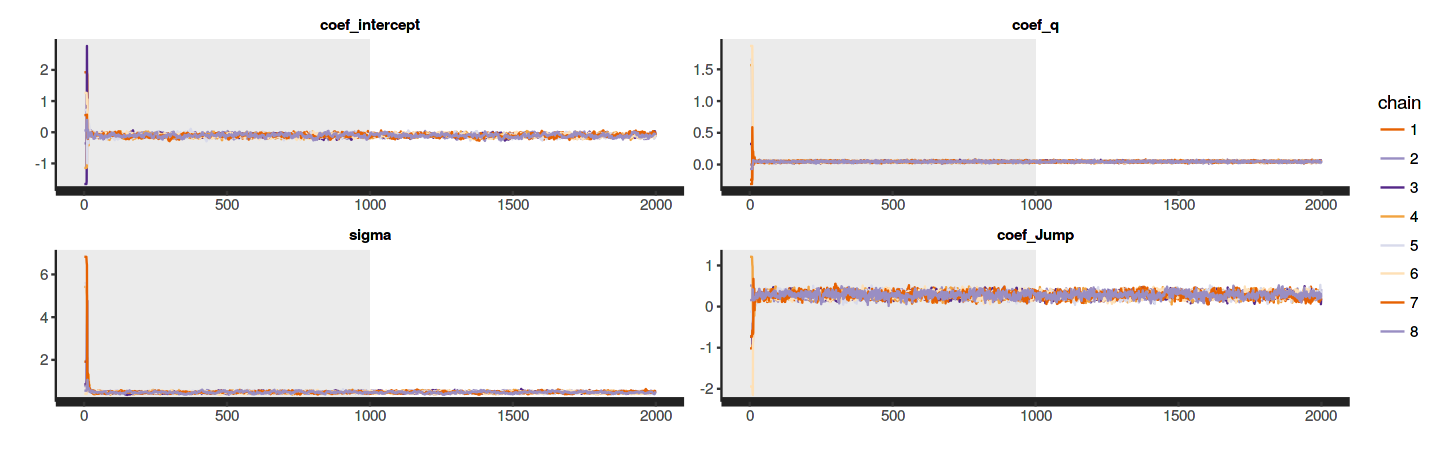

In [136]:
#Plot traces for the two models
options(repr.plot.width=12, repr.plot.height=3.8)
traceplot(stan_wd1, pars=c("coef_intercept", "coef_q", "sigma", "coef_Jump"), inc_warmup=T)
traceplot(stan_wd1_1000, pars=c("coef_intercept", "coef_q", "sigma", "coef_Jump"), inc_warmup=T)

   ## 3.2 Model Coefficients
   As we can see below, our Predictive Models are able to reconstruct true model parameters fairly well. 
   
   In general we can see that with more data, we get closer to the true value and the PDF is narrower since the confidence increases.

In [29]:
#stan_wd1_result      <- readRDS("./out/stan_wd1_result.rds")
#stan_wd1_1000_result <- readRDS("./out/stan_wd1_1000_result.rds")

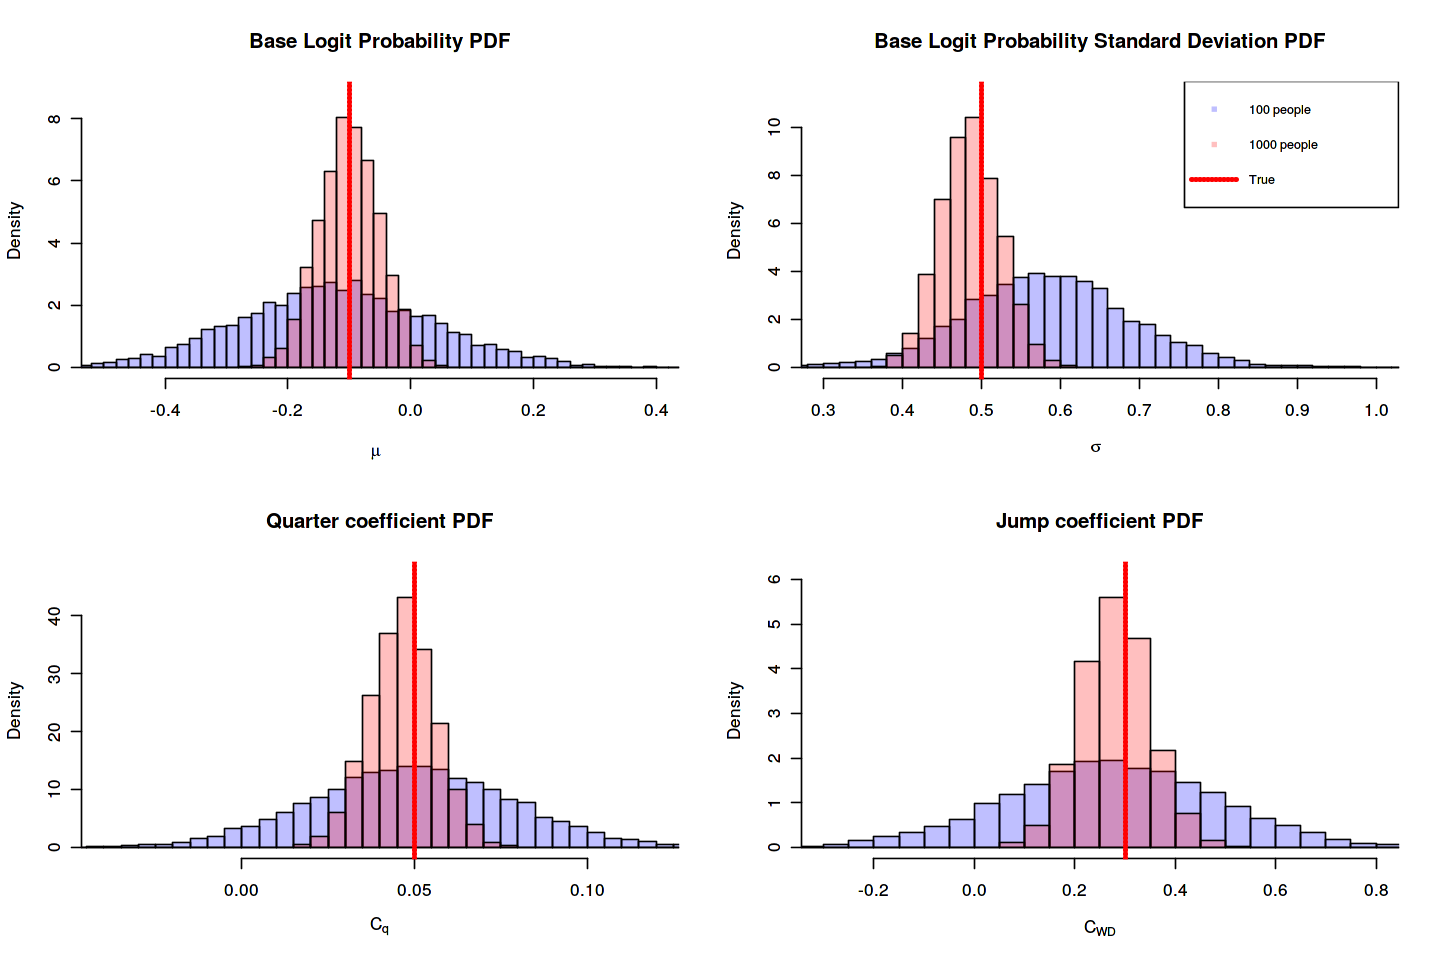

In [221]:
# Here we plot the Intercept parameter (base logit withdrawal probability) 
# estimation from the two models (100 and 1000 people) 
# and the true value that was used in simulation
source("./WDUtilityFunctions.R")
#png(filename="./Paper/figs/fig3.png")

options(repr.plot.width=12, repr.plot.height=8)
#par(mfrow=c(2,2))
par(mfrow=c(2,2))
plot_2_histograms(stan_wd1_result$coef_intercept, stan_wd1_1000_result$coef_intercept, breaks=50,
                  trueValue = TrueSimulatedPars_Symmetric$Intercept,
                  legend1="100 people", legend2="1000 people",
                  xlab=expression(mu),
                  main="Base Logit Probability PDF",
                  plot_legend=F,
                  xlim=c(-0.5,0.4)
                 )
plot_2_histograms(stan_wd1_result$sigma, stan_wd1_1000_result$sigma, breaks=50,
                  trueValue = TrueSimulatedPars_Symmetric$Intercept_scale,
                  legend1="100 people", legend2="1000 people",
                  xlab=expression(sigma),
                  main="Base Logit Probability Standard Deviation PDF",
                  #plot_legend=F,
                  xlim=c(0.3,1),
                  y.intersp=1.8,
                  text.width_scale=0.85,
                  #legend_position="topleft"
                  scale_text=0.6
                  
                 )
plot_2_histograms(stan_wd1_result$coef_q, stan_wd1_1000_result$coef_q, breaks=50,
                  trueValue = TrueSimulatedPars_Symmetric$q_coef,
                  legend1="100 people", legend2="1000 people",
                  xlab=expression("C"["q"]),
                  main="Quarter coefficient PDF",
                  plot_legend=F,
                  xlim=c(-0.04,0.12)
                 )
plot_2_histograms(stan_wd1_result$coef_Jump, stan_wd1_1000_result$coef_Jump, breaks=50,
                  trueValue = TrueSimulatedPars_Symmetric$CJump,
                  legend1="100 people", legend2="1000 people",
                  xlab=expression("C"["WD"]),
                  main="Jump coefficient PDF",
                  plot_legend=F,
                  xlim=c(-0.3,0.8)
                 )
#dev.off()

   ## 3.3 Base Logit Withdrawal Probabilities for Individual People

Using Bayesian model we can infer Base Logit Withdrawal Probabilities.

Here is a plot of the Base Logit Withdrawal Probabilities for the first two people in the simulation (these are the same people for which we made a above plot of withdrawal probabilities as a function of SimulationID)

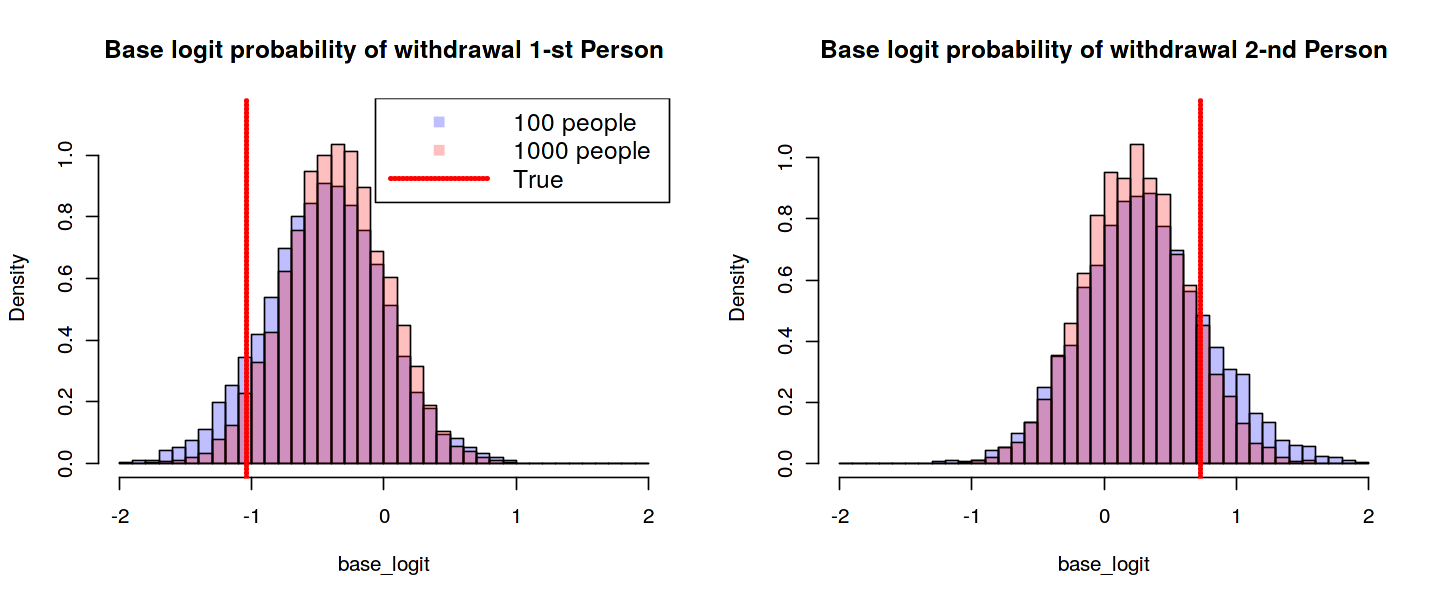

In [222]:
source("./WDUtilityFunctions.R")

#png(filename="./Paper/figs/fig4.png", width = 880, height = 480)

options(repr.plot.width=12, repr.plot.height=5)
par(mfrow=c(1,2))

brr = seq(-2,2,0.1)
plot_2_histograms(stan_wd1_result$wd_prob_link[,1], stan_wd1_1000_result$wd_prob_link[,1], breaks=brr,
                  trueValue = df_symmetric[df_symmetric$q==1,]$wd_prob_link[1],
                  legend1="100 people", legend2="1000 people",
                  xlab="base_logit",
                  main="Base logit probability of withdrawal 1-st Person",
                  plot_legend=T,
                  xlim=c(-2,2)
                 )

plot_2_histograms(stan_wd1_result$wd_prob_link[,2], stan_wd1_1000_result$wd_prob_link[,2], breaks=brr,
                  trueValue = df_symmetric[df_symmetric$q==1,]$wd_prob_link[2],
                  legend1="100 people", legend2="1000 people",
                  xlab="base_logit",
                  main="Base logit probability of withdrawal 2-nd Person",
                  plot_legend=F,
                  xlim=c(-2,2)
                 )

#dev.off()

As we can see, The **Person 2** has higher inferred base logit probability as we do observe more withdrawals for him than for the **Person 1**.

Having more transverse data(more people) helps a little bit as the distributions get a little narrower. This is because we have a much better understanding of the model coefficients.

However, the difference is not very big, because we observe only 10 quarters for a given person. So, in this toy model if we are predicting withdrawal probability for individual people, we would like more of the longitudinal data (more observed quarters)

# Conclusion

In this notebook we constructed a toy model that may be applicable for studying Variable Annuity policy holder behavior. We used a simulation so that we fully understand the input data and the underlying true model.

For modeling we used Bayesian model using Stan. All resulting inferred distributions made sense. As the amount of training data increases, the inferred distributions become narrower and closer to the true values.

This may serve as a good example for the reader in how to use Bayesian inference.